In [1]:
#import statements
import pandas as pd
import numpy as np
from numpy.linalg import norm
from numpy import dot
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
import matplotlib

# Task 1

Load the data and identify and treat possible missing values

In [2]:
recipes=pd.read_csv('recipes.csv')
recipes=recipes.drop("Unnamed: 0", axis=1) #Dropped unwanted column              
recipes.replace(to_replace='^ $', value=np.nan, regex=True, inplace=True) #Doesn't have recognisable na or null, na here is an empty string
#print(recipes.isna().sum())   #Uncomment to view - (there is 50 for category, 1419 for cuisine)
recipes=recipes.fillna("Unknown") #Only "Unknown" column will be dropped in features for below recommmender systems and models, to avoid deleting a significat amount of rows
#print(recipes.isna().sum())   #Uncomment to view (there is none) 
#print(recipes.isnull().sum()) #Uncomment to view (there is none)

#print(recipes.dtypes)#Uncomment to view
#Correcting dtypes
recipes['title'] = recipes['title'].astype("string")
recipes['image_url'] = recipes['image_url'].astype("string")
recipes['recipe_url'] = recipes['recipe_url'].astype("string")
recipes['category'] = recipes['category'].astype("string")
recipes['cuisine'] = recipes['cuisine'].astype("string")
recipes['ingredients'] = recipes['ingredients'].astype("string")
#print(recipes.dtypes)#Uncomment to view

Show the summary statistics 

In [3]:
print(recipes.shape)       #3293 rows, 10 columns
print(recipes.describe())  #Summary statistics

(3293, 10)
                id   rating_avg   rating_val   total_time
count  3293.000000  3293.000000  3293.000000  3293.000000
mean   1647.000000     4.497432    12.038567   127.227452
std     950.751545     0.611602    25.221305   156.363779
min       1.000000     1.000000     1.000000    30.000000
25%     824.000000     4.250000     3.000000    60.000000
50%    1647.000000     4.666667     6.000000    90.000000
75%    2470.000000     5.000000    13.000000   150.000000
max    3293.000000     5.000000   776.000000   840.000000


Show the 10 highest rated recipes

In [4]:
recipesSort=(recipes.sort_values(by="rating_avg", ascending=False)) #Sorts by rating average
print(recipesSort.head(10))

        id                                title  \
1646  1647                 Ma's macadamia salad   
2419  2420                              Sangria   
842    843         Cranberry and grape focaccia   
840    841  Cranberry and chilli brioche wreath   
1773  1774               Middle Eastern lentils   
838    839                 Crackling pork belly   
837    838                    Crackle top bread   
836    837                        Crab linguine   
2411  2412    Salted caramel and coffee éclairs   
834    835              Crab and scallop Mornay   

                                              image_url  \
1646  https://food-images.files.bbci.co.uk/food/reci...   
2419  https://food-images.files.bbci.co.uk/food/reci...   
842   https://food-images.files.bbci.co.uk/food/reci...   
840   https://food-images.files.bbci.co.uk/food/reci...   
1773  https://food-images.files.bbci.co.uk/food/reci...   
838   https://food-images.files.bbci.co.uk/food/reci...   
837   https://food-images

# Task 2

Visualise the average ratings and the number of ratings and comment on any relationship that exist between rating_avg and rating_val.

#### First we'll try and see if there is any correlation for the data (excluding outliers calculated)

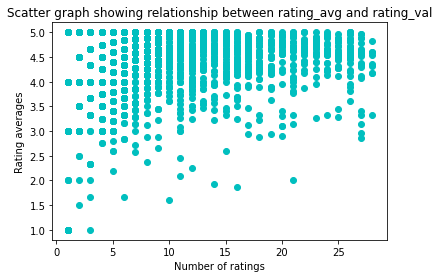

In [5]:
recipesPlot=recipes                           #Use this dataframe for task 2
q1 = recipesPlot['rating_val'].quantile(0.25) #Gets the lower quartile
q3 = recipesPlot['rating_val'].quantile(0.75) #Gets the upper quartile
iqr = q3 - q1                                 #Calculates the Interquartile range
lowerOutlierLimit=q1-(iqr*1.5)                #Calculates the "lower limit" with the outlier formula
upperOutlierLimit=q3+(iqr*1.5)                #Calculates the "upper limit" for finding outliers , where any rating amount values higher is excluded as an outlier
#print(lowerOutlierLimit) #Lower outlier limit = -12. As rating value amounts can't be lower than 0, this will not have an effect
#print(upperOutlierLimit) #upper outlier limit = 28 .

outliers = (recipesPlot['rating_val'] < lowerOutlierLimit) | (recipesPlot['rating_val'] > upperOutlierLimit) #Finds outlers in recipesPlot
recipesPlot = recipesPlot.drop(recipesPlot.loc[outliers].index)  #Drops 270 outliers (8.1992% of original data)

rating_avg_points=np.array(recipesPlot['rating_avg']) #An array of rating_avg
rating_val_points=np.array(recipesPlot['rating_val']) #An array of rating_val

plt.scatter(rating_val_points, rating_avg_points, color='c')
plt.title("Scatter graph showing relationship between rating_avg and rating_val")
plt.xlabel("Number of ratings")
plt.ylabel("Rating averages")
plt.show()



### Comment on relationship found in graph above
#### Here we are using a scatter graph to try and look for any sort of pattern between rating averages and the number of ratings. 

#### We can see that for a smaller number of ratings (less than 5 ish) the rating averages plotted have a lot of spread and range, and as the number of ratings for a recipe increase in the graph, the rating averages become more consistent and less spread. 

#### As the number of ratings increase, the rating averages are more grouped towards a higher rating_avg than compared to having a small rating_avg

#### This could be because popular recipes are those that have high ratings to them from the start, so they are shared around more as they are higher quality, and thus gain more higher ratings, without recieving a lot of greatly negative ratings.

#### And those that are not good enough at the start don't get much ratings as people don't attempt the recipe due to their bad rating_avg as it indicates a low quality recipe, so users would look for another higher quality recipe

#### Next we'll plot a 2d histogram plot, where each bin represents the frequency of data points.
#### The purpose of this is to group the frequency of data points within ranges of values.

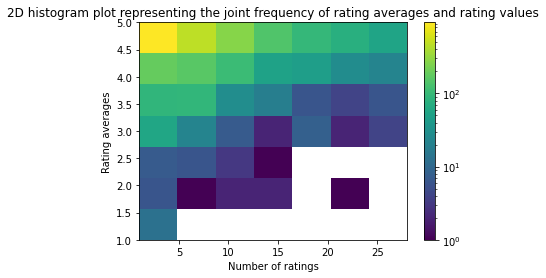

In [6]:
plt.hist2d(rating_val_points,rating_avg_points, bins=7, norm=matplotlib.colors.LogNorm())

plt.colorbar() #Shows level of frequency
plt.title('2D histogram plot representing the joint frequency of rating averages and rating values')
plt.xlabel("Number of ratings")
plt.ylabel("Rating averages")
plt.show()

## Comment on relationship found in graph above

#### The above graph shows us that a significant amount of recipes have a high rating average (>4.4) and are from recipes where the amount of ratings given are from a few amount of users.
#### We can also see that for recipes where the number of ratings given are more per recipe, the frequency of these recipes with a high rating average decreases 

#### The next final graph shows the distribution of rating _avg against rating_val, and will be used to suggest a threshold

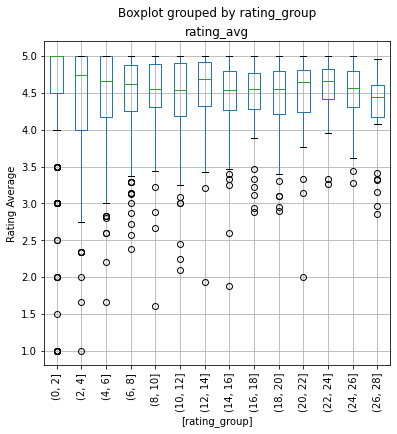

In [7]:
groupingRatingValue = [0, 2,4, 6,  8, 10,  12 , 14, 16, 18, 20, 22, 24, 26, 28]
recipesPlot['rating_group'] = pd.cut(recipesPlot['rating_val'], bins=groupingRatingValue) #Separate the column values into different bins

fig = plt.figure(figsize=(6, 6)) #To help data visually overlapping
fig.clf()                        #To avoid overlap with previous plots
ax = fig.gca()                   #Gets the axes objects, to help with creating the boxplot
recipesPlot.boxplot(column=['rating_avg'], ax=ax, by=['rating_group']) #Plots boxplot
ax.set_ylabel('Rating Average')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)    #Aligns x-axis labels vertically to avoid text overlap
plt.show()


## Comment on relationship found in graph above and a threshold suggestion for the number of ratings under which the rating can be considered as not significant.

#### Here we have plotted box plot for pairs of values until 28 (the upper limit where a rating_val is not an outlier)

#### A key thing to notice here is that as rating_val increases, the spread of rating averages decreases and become more consistent, and there is less range in the outliers.

#### From 1 to 6, there are more outliers spread out over most/all of possible rating averages, and after 6, the spread of outliers and values noticeably decreases and the points become closer to each other, showing more consistency in rating averages reflecting the quality of a recipe.

## From this I will suggest a threshold where any rating_val equal to or under 6 should be ignored and considered as not significant, as the data is too erratic for them. Also as if there is less than 6 people giving a rating for a recipe, each of their views carries too much weight on the overall recipe rating average, causing too much bias, so should be ignored


# Task 3

Consider features:features=['title','rating_avg','rating_val','total_time','category','
cuisine', 'ingredients']


a) Add to your dataframe a column combine_features, which combines all the
contents of the features in the given list features as a single string wherein
each feature’s contents is separated from the other by one space string.

In [8]:
combine_features=[]
for i in recipes.index:  #iterates over each row in recipes dataframe
    item=(recipes.loc[i, "title"])+" "+str(recipes.loc[i, "rating_avg"])+" "+str(recipes.loc[i, "rating_val"])+" "+str(recipes.loc[i, "total_time"])+" "+(recipes.loc[i, "category"])+" "+(recipes.loc[i, "cuisine"])+" "+(recipes.loc[i, "ingredients"]) #concatenates all features to include
    combine_features.append((item))
    
#Converts the 2 lists to pandas series objects
combine_features = pd.Series(combine_features) 

#Adds to the main dataframe (recipes) the combine_features column
recipes['combine_features'] = combine_features


b) Using the class CountVectorizer and the function cosine_similarity,
compute the cosine similarity matrix from the resulting dataframe of the
combined features

In [9]:
count_vectorizer = CountVectorizer(stop_words='text') # Creates the terms matrix, ignoring common no-meaning words (such as "a")
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(combine_features) #sparse matrix only stores non zero values, to be more memory efficient
doc_term_matrix=sparse_matrix.todense() #This is converted to dense matrix (which also stores 0s), but is needed for creating the cosine similarity matrix

features_matrix = pd.DataFrame(doc_term_matrix,columns=count_vectorizer.get_feature_names()) #Converts to a dataframe with the features as column names
features_matrix=features_matrix.drop("unknown", axis=1) #Drop the nan column without dropping anywhole recipe rows, as it is not a distinctive feature

cosine_similarity_matrix=(cosine_similarity(features_matrix, features_matrix)) #Calculates cosine similarity between all pairs of recipes

print(cosine_similarity_matrix)

C:\Users\mgadi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[[1.         0.         0.         ... 0.09544271 0.0855921  0.03846154]
 [0.         1.         0.         ... 0.24525574 0.20619652 0.1111874 ]
 [0.         0.         1.         ... 0.05735393 0.         0.        ]
 ...
 [0.09544271 0.24525574 0.05735393 ... 1.         0.24779731 0.15907119]
 [0.0855921  0.20619652 0.         ... 0.24779731 1.         0.1711842 ]
 [0.03846154 0.1111874  0.         ... 0.15907119 0.1711842  1.        ]]


C) Consider the recipe ‘Chicken and coconut curry’. Relying on the vector space
method, use a matrix-vector product to show the first 10 recipe
recommendations for a user who has liked that particular recipe. Show the
titles of these recommendations

In [10]:
#Note : Row index = recipeID - 1
features_matrix_normalised=features_matrix
features_matrix_normalised=features_matrix_normalised.apply(lambda cell: (cell/norm(cell)), axis=1) #Normalises the feature matrix
targetRecipeData=features_matrix_normalised.loc[476] #Row location of 'Chicken and coconut curry'

dotCalculation=(features_matrix_normalised.dot(targetRecipeData)) #Performs dot product between feature vector of the target recipe, and the normalised feature matrix

#Stores the recipe recommendations in descending order in a new dataframe, and prints out top 10
similar_to_targetRecipe = pd.DataFrame(dotCalculation, columns = ['similarity'])
top_10_recommendations=similar_to_targetRecipe.sort_values(by='similarity', ascending=False).head(11)
print("Top 10 recommendations 'Chicken and coconut curry' ")
for i in top_10_recommendations.index[1:11]:
    print(("Recipe ID: ", i+1, "Name: ",recipes.iloc[i, 1], "Similarity: ",top_10_recommendations.loc[i][0]))

        
#Uncomment for double check
#firstRecommendation=features_matrix_normalised.loc[3004] #Row location for 'Vegan blackeye bean curry' - which is most similar recipe
#cosine_similarity(targetRecipeData.to_numpy().reshape(1,2493), firstRecommendation.to_numpy().reshape(1, 2493)) #Gives 0.74194083 which matches similarity

Top 10 recommendations 'Chicken and coconut curry' 
('Recipe ID: ', 3005, 'Name: ', 'Vegan blackeye bean curry', 'Similarity: ', 0.7419408268023738)
('Recipe ID: ', 1448, 'Name: ', 'Indian fish curry', 'Similarity: ', 0.653537383101465)
('Recipe ID: ', 1478, 'Name: ', 'Jamaican chicken curry', 'Similarity: ', 0.6535373831014649)
('Recipe ID: ', 1571, 'Name: ', 'Leftover chicken curry', 'Similarity: ', 0.6454234490405723)
('Recipe ID: ', 507, 'Name: ', 'Chicken curry (shorshe murgi)', 'Similarity: ', 0.636396103067893)
('Recipe ID: ', 509, 'Name: ', 'Chicken curry with basmati rice', 'Similarity: ', 0.6340751391209737)
('Recipe ID: ', 2499, 'Name: ', 'Simple chicken curry', 'Similarity: ', 0.6154574548966636)
('Recipe ID: ', 777, 'Name: ', 'Coconut fish curry', 'Similarity: ', 0.6037383539249432)
('Recipe ID: ', 488, 'Name: ', 'Chicken and vegetable balti', 'Similarity: ', 0.5987641593469991)
('Recipe ID: ', 1210, 'Name: ', 'Goan fish curry', 'Similarity: ', 0.5976143046671967)


# Task 4

Write a function, vec_space_method, which takes in a recipe and returns the 10 most
similar recipes to the given one. Do this using a suitable matrix-vector product in the
Vector Space Method. This has to be different from what is carried out in Part 1.3
since you have considered the entire dataset.

In [11]:
def vec_space_method(recipeName):
    """
    This function takes a recipe name as an input and recommends 10 similar recipes
    based on their features (ingredients, category, cuisine, total time, rating average, title) and using the Vector Space Method.
    It returns the top 10 recommended recipes with their recipe ID, name and similarity score.
    """
    recipesFiltering=recipes
   
    recipeNameIndex=(recipes.loc[recipes['title'] == recipeName].index)[0] #Locates row number of target recipe name
    recipeNameIngredients=recipes.loc[recipeNameIndex]['ingredients']      #Locates ingredients column of target recipe
    recipeNameIngredients=recipeNameIngredients.split(',') #Splits ingredients into a list  
    
    feat1=recipesFiltering['ingredients'].str.get_dummies(sep=',') #Converts to a binary matrix
    feat1 = feat1[feat1.columns[feat1.columns.isin(recipeNameIngredients)]] #Only includes ingredient columns as part of the target recipe's ingredients, not the whole database collection of ingredients
    feat1=feat1/norm(feat1)  #Normalisation
  
    feat2=recipesFiltering['category'].str.get_dummies() #Converts to binary matrix
    feat2=feat2.drop(columns=['Unknown']) #Drops Unknown columns as it is not a distinctive feature (instead of dropping the entire row earlier at the beginning of notebook)
    feat2=feat2/norm(feat2) #Normalisation
   
    feat3=recipesFiltering['cuisine'].str.get_dummies() #Converts to binary matrix
    feat3=feat3.drop(columns=['Unknown']) #Drops Unknown columns as it is not a distinctive feature (instead of dropping the entire row earlier at the beginning of notebook)
    feat3=feat3/norm(feat3) #Normalisation
 
    feat4=recipesFiltering['total_time']
    feat4=feat4/norm(feat4) #Normalisation
    
    feat5=recipesFiltering['rating_avg']
    feat5=feat5/norm(feat5) #Normalisation
    
    
    #Converts recipe titles to a binary matrix (leaving out non meaningful words such as 'a') 
    vectorizer = CountVectorizer(stop_words='english')
    feat6=pd.DataFrame(vectorizer.fit_transform(recipesFiltering['title']).todense(), columns=vectorizer.get_feature_names())
    
    keyWordsRecipeName=recipeName.split() #Creates a list where each word is a word in the target recipe's title
    keyWordsRecipeName=[word.lower() for word in keyWordsRecipeName]
    feat6 = feat6[feat6.columns[feat6.columns.isin(keyWordsRecipeName)]] #Only includes the target recipe's title terms, not all throughout the dataframe
    feat6=feat6/norm(feat6) #Normalisation
    
    #Merges all normalised feature matrices
    features=feat1.merge(feat2, left_index=True, right_index=True)
    features=features.merge(feat3, left_index=True, right_index=True)
    features=features.merge(feat4, left_index=True, right_index=True)
    features=features.merge(feat5, left_index=True, right_index=True)
    features=features.merge(feat6, left_index=True, right_index=True)
    features_normalised=features.apply(lambda cell: (cell/norm(cell)), axis=1) #Normalisation
   
    targetRecipe=features_normalised.loc[recipeNameIndex] #Gets the target recipe row
    dotCalc=features_normalised.dot(targetRecipe) #Performs dot product and all the other rows of the combined features matrix
    
    #Stores the recipe recommendations in descending order in a new dataframe, and prints out top 10
    similar_to_targetRecipe = pd.DataFrame(dotCalc, columns = ['similarity'])
    top_10=similar_to_targetRecipe.sort_values(by='similarity', ascending=False).head(15)
    print("Recipe recommendations for "+recipeName)
    for i in top_10.index[1:11]:
        print(("Recipe ID: ", i+1, "Name: ",recipes.iloc[i, 1], "Similarity: ",top_10.loc[i][0]))
    
vec_space_method('Chicken and coconut curry')

C:\Users\mgadi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Recipe recommendations for Chicken and coconut curry
('Recipe ID: ', 507, 'Name: ', 'Chicken curry (shorshe murgi)', 'Similarity: ', 0.7909190324429853)
('Recipe ID: ', 2817, 'Name: ', 'Suriani home-style chicken curry (‘ishtu’)', 'Similarity: ', 0.7858149771473384)
('Recipe ID: ', 2521, 'Name: ', 'Slow cooker chicken curry', 'Similarity: ', 0.7765850159273674)
('Recipe ID: ', 92, 'Name: ', 'Baked chicken curry', 'Similarity: ', 0.7765438241708553)
('Recipe ID: ', 777, 'Name: ', 'Coconut fish curry', 'Similarity: ', 0.7755560066680673)
('Recipe ID: ', 2193, 'Name: ', 'Quick beef massaman curry with coconut rice', 'Similarity: ', 0.7751317348031104)
('Recipe ID: ', 3290, 'Name: ', 'Punjabi chicken curry ', 'Similarity: ', 0.7675682707501367)
('Recipe ID: ', 608, 'Name: ', 'Chinese chicken curry', 'Similarity: ', 0.766988201443561)
('Recipe ID: ', 1478, 'Name: ', 'Jamaican chicken curry', 'Similarity: ', 0.7648455538296518)
('Recipe ID: ', 909, 'Name: ', 'Dad’s Chinese chicken curry', 'S

# Task 5

Write a function, knn_similarity, which takes in a recipe and returns the 10 most similar
recipes to the given one. Do this considering the entire dataset and using the KNN
algorithm.

In [12]:
def knn_similarity(recipeName):
    """
    This function takes a recipe name as an input and recommends 10 similar recipes
    based on their features (ingredients, category, cuisine, total time, rating average, title, rating value) and using the K-Nearest Neighbours algorithm.
    It returns the top 10 recommended recipes with their name and similarity score.
    """
    recipesFiltering=recipes
   
    feat1=recipesFiltering['ingredients'].str.get_dummies(sep=',') #Converts to binary matrix
    feat1=feat1/norm(feat1) #Normalises
    
    feat2=recipesFiltering['category'].str.get_dummies() #Converts to binary matrix
    feat2=feat2.drop(columns=['Unknown']) #Drops the column as it is not a distinctive feature
    feat2=feat2/norm(feat2) #Normalises
   
    feat3=recipesFiltering['cuisine'].str.get_dummies() #Converts to binary matrix
    feat3=feat3.drop(columns=['Unknown']) #Drops the column as it is not a distinctive feature
    feat3=feat3/norm(feat3) #Normalises
    
    feat4=recipesFiltering['total_time']
    feat4=feat4/norm(feat4) #Normalises
   
    feat5=recipesFiltering['rating_avg']
    feat5=feat5/norm(feat5) #Normalises

    #Converts recipe titles to a binary matrix (leaving out non meaningful words such as 'a') 
    vectorizer = CountVectorizer(stop_words='english')
    feat6=pd.DataFrame(vectorizer.fit_transform(recipesFiltering['title']).todense(), columns=vectorizer.get_feature_names())
    feat6=feat6/norm(feat6) #Normalises

    feat7=recipesFiltering['rating_val']
    feat7=feat7/norm(feat7) #Normalises

    #Merges all the features into a big dataframe
    features=feat1.merge(feat2, left_index=True, right_index=True)
    features=features.merge(feat3, left_index=True, right_index=True)
    features=features.merge(feat4, left_index=True, right_index=True)
    features=features.merge(feat5, left_index=True, right_index=True)
    features=features.merge(feat6, left_index=True, right_index=True)
    features=features.merge(feat7, left_index=True, right_index=True)
    
    sparseMatrix=csr_matrix(features.values) #Creates a sparse matrix from the features dataframe
    
    knn_model = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=20, n_jobs=-1) #Iniitalises the KNN model
    knn_model.fit(sparseMatrix) #Fits the sparseMatrix
    
    recipeIndex=recipes.loc[recipes['title'] == recipeName].index #Gets the row index of the target recipe
    pt_of_interest=features.iloc[recipeIndex[0], :] #Gets the target recipe corresponding details rom the features dataframe
    pt_of_interest=pt_of_interest.to_numpy() #Converts to numpy array (so it can be reshaped)
    
    dist, ind = knn_model.kneighbors(pt_of_interest.reshape(1, -1) , n_neighbors=11) #Calculates the distance and index of k-nearest neighbours
    
    #Prints out the top 10 recipe recommendations
    print("Recommendation for "+recipeName)
    for i in range(1, len(dist.flatten())):
        print('{0}: {1} with similarity of {2}'.format(i, recipes.iloc[ind.flatten()[i]]['title'], (1-(dist.flatten()[i]))))


knn_similarity('Chicken and coconut curry')




C:\Users\mgadi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Recommendation for Chicken and coconut curry
1: Salmon curry  with similarity of 0.7562173131636669
2: Chicken and vegetable balti with similarity of 0.7546210615394816
3: Chicken curry (shorshe murgi) with similarity of 0.7318778697139526
4: Chicken curry for one with similarity of 0.7318052132496718
5: Kidney bean and pineapple curry  with similarity of 0.7237371073996939
6: Quick vegetable curry with similarity of 0.7229329275843159
7: Peanut butter chicken with similarity of 0.7121551516624562
8: Roast chicken with similarity of 0.7088175953607129
9: Beef curry with shatkora with similarity of 0.7046621375168924
10: Chicken pithivier with similarity of 0.7003586763069803


# Task 6

Consider the following test set composed of four users: 

User 1 likes ‘Chicken tikka masala’

User 2 likes ‘Albanian baked lamb with rice’

User 3 likes ‘Baked salmon with chorizo rice’

User 4 likes ‘Almond lentil stew’


Using this test set, evaluate both recommender systems you have built up in Part 2.4
and 2.5 in terms of coverage and personalisation. You can add comments on this
evaluation into your submitted Python code file

## Coverage for 2.4

#### 2.4 only gives the top 10 most similar recommendations, so as there are a total of 3292 recipes it can recommend (minus 1 as the target recipe cannot be recommended against itself), so coverage=(10/3292)*100 = 0.304% coverage ,meaning that the recommender system is only recommending 0.304% of all available recipes to the user

#### This recommender system is only recommending a very small subset of recipes. This could have further implications, such as the user not being able to be exposed to and explore a wide range of new recipes. However 10 is a standard amount of recommendations and suggesting more may cause information overload to the user, as it is known that a user spends more time making a decision when they have more options presented to them, which eventually leads to user frustration.

## Coverage for 2.5

#### 2.5 only gives the top 10 most similar recommendations, so as there are a total of 3292 recipes it can recommend (minus 1 as the target recipe cannot be recommended against itself), so coverage=(10/3292)*100 = 0.304% coverage ,meaning that the recommender system is only recommending 0.304% of all available recipes to the user 

#### This recommender system is only recommending a very small subset of recipes. This could have further implications, such as the user not being able to be exposed to and explore a wide range of new recipes. However 10 is a standard amount of recommendations and suggesting more may cause information overload to the user, as it is known that a user spends more time making a decision when they have more options presented to them, which eventually leads to user frustration.

## Personalisation for 2.4

#### First we list all the recommendations for the 4 user liked recipes

In [13]:
#Listing recommendations
vec_space_method('Chicken tikka masala')
vec_space_method('Albanian baked lamb with rice (Tavë kosi)')
vec_space_method('Baked salmon with chorizo rice')
vec_space_method('Almond lentil stew')



C:\Users\mgadi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Recipe recommendations for Chicken tikka masala
('Recipe ID: ', 3257, 'Name: ', 'Low-fat chicken tikka masala', 'Similarity: ', 0.8362395107658351)
('Recipe ID: ', 964, 'Name: ', 'Easy chicken tikka masala', 'Similarity: ', 0.8189139704086429)
('Recipe ID: ', 563, 'Name: ', 'Chicken tikka and naan bread', 'Similarity: ', 0.7711313807647109)
('Recipe ID: ', 325, 'Name: ', 'Butter chicken   ', 'Similarity: ', 0.7588662004448198)
('Recipe ID: ', 2304, 'Name: ', 'Roast chicken masala and potatoes', 'Similarity: ', 0.7562300238736078)
('Recipe ID: ', 3281, 'Name: ', 'Oven-fried chicken', 'Similarity: ', 0.7371983354802497)
('Recipe ID: ', 2853, 'Name: ', 'Tandoori chicken lollipop drumsticks with raita dip', 'Similarity: ', 0.7276740206622327)
('Recipe ID: ', 3218, 'Name: ', 'Duck tikka', 'Similarity: ', 0.7201959479586936)
('Recipe ID: ', 1016, 'Name: ', 'Easy tandoori chicken', 'Similarity: ', 0.7149487105064253)
('Recipe ID: ', 475, 'Name: ', 'Chicken and chorizo stew', 'Similarity: ', 0

C:\Users\mgadi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Recipe recommendations for Albanian baked lamb with rice (Tavë kosi)
('Recipe ID: ', 103, 'Name: ', 'Baked salmon with chorizo rice', 'Similarity: ', 0.6991222325518001)
('Recipe ID: ', 93, 'Name: ', 'Baked chicken, prawn and chorizo rice', 'Similarity: ', 0.6991141153110534)
('Recipe ID: ', 65, 'Name: ', 'Aubergines in tamarind sauce with baked halloumi and saffron rice', 'Similarity: ', 0.6836291761263908)
('Recipe ID: ', 1819, 'Name: ', 'Moroccan lamb lasagne ', 'Similarity: ', 0.5369492044277149)
('Recipe ID: ', 2329, 'Name: ', 'Roast shoulder of lamb with herbs and honey', 'Similarity: ', 0.5275239993799877)
('Recipe ID: ', 3149, 'Name: ', 'Whole baked sea bass on potatoes', 'Similarity: ', 0.5275167687895268)
('Recipe ID: ', 1631, 'Name: ', 'Lighter lamb hotpot', 'Similarity: ', 0.5274832139757322)
('Recipe ID: ', 2647, 'Name: ', 'Spiced lamb shanks', 'Similarity: ', 0.5274355902319764)
('Recipe ID: ', 100, 'Name: ', 'Baked potato with bacon, taleggio and leek', 'Similarity: ', 0

C:\Users\mgadi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Recipe recommendations for Baked salmon with chorizo rice
('Recipe ID: ', 93, 'Name: ', 'Baked chicken, prawn and chorizo rice', 'Similarity: ', 0.8416209541118753)
('Recipe ID: ', 474, 'Name: ', 'Chicken and chorizo rice', 'Similarity: ', 0.7068936950520484)
('Recipe ID: ', 102, 'Name: ', 'Baked salmon and couscous parcels', 'Similarity: ', 0.7068936376467795)
('Recipe ID: ', 701, 'Name: ', 'Chorizo and butterbean stew with baked potatoes', 'Similarity: ', 0.6952386674480435)
('Recipe ID: ', 104, 'Name: ', 'Baked salmon with parmesan and parsley crust', 'Similarity: ', 0.6889208506864963)
('Recipe ID: ', 65, 'Name: ', 'Aubergines in tamarind sauce with baked halloumi and saffron rice', 'Similarity: ', 0.6885024296060478)
('Recipe ID: ', 4, 'Name: ', 'Albanian baked lamb with rice (Tavë kosi)', 'Similarity: ', 0.6824274158438997)
('Recipe ID: ', 891, 'Name: ', 'Crispy salmon, polenta chips and grilled asparagus', 'Similarity: ', 0.5552067885880865)
('Recipe ID: ', 554, 'Name: ', 'Chick

C:\Users\mgadi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Recipe recommendations for Almond lentil stew
('Recipe ID: ', 1620, 'Name: ', 'Lentil stew with sweet onions', 'Similarity: ', 0.7888047011081547)
('Recipe ID: ', 2431, 'Name: ', 'Sausage and lentil stew ', 'Similarity: ', 0.7744344279264935)
('Recipe ID: ', 1618, 'Name: ', "Lentil shepherd's pie", 'Similarity: ', 0.6009392603560579)
('Recipe ID: ', 1615, 'Name: ', 'Lentil bolognese', 'Similarity: ', 0.59481932934646)
('Recipe ID: ', 3288, 'Name: ', 'Pumpkin stew with sour cream', 'Similarity: ', 0.5947592959214698)
('Recipe ID: ', 3291, 'Name: ', 'Puy lentil lasagne', 'Similarity: ', 0.5886982606385827)
('Recipe ID: ', 2574, 'Name: ', 'Smoked pancetta and lentil soup', 'Similarity: ', 0.5886932962504625)
('Recipe ID: ', 1307, 'Name: ', 'Healthy bacon and lentil soup', 'Similarity: ', 0.585721408047613)
('Recipe ID: ', 1053, 'Name: ', 'Fennel and butternut squash stew with cannellini beans', 'Similarity: ', 0.5822685648140702)
('Recipe ID: ', 443, 'Name: ', 'Cheesy bean and lentil bake

#### We make a binary matrix of the recommendations for each user liked recipe. Here there are 38 unique recipes, as 2 of the recipes ("Baked chicken, prawn and chorizo rice" and "Aubergines in tamarind sauce with baked halloumi and saffron rice") appear in the recommendations for the second and third user liked recipe


#### We then produce a cosine similarity matrix from the binary matrix, and calculate the average cosine similarity by averageing the "upper triangle values". 

#### We finally calculate the personalisation metric, which is 1-average cosine similarity, which equals to 0.9666666666666667 for this vector space recommender system.

#### This value of 0.9666.. implies that the recommender system is able to recommend items that are highly personalised to the user's preferences.

#### The code for all this is below:

In [14]:
#Producing the binary matrix
evaluatingVectorSpaceMethod = pd.DataFrame({
    #First recipe 10
    'Low-fat chicken tikka masala': [1, 0, 0, 0],
    'Easy chicken tikka masala': [1, 0, 0, 0],
    'Chicken tikka and naan bread': [1, 0, 0, 0],
    'Butter chicken': [1, 0, 0, 0],
    'Roast chicken masala and potatoes': [1, 0, 0, 0],
    'Oven-fried chicken': [1, 0, 0, 0],
    'Tandoori chicken lollipop drumsticks with raita dip': [1, 0, 0, 0],
    'Duck tikka': [1, 0, 0, 0],
    'Easy tandoori chicken': [1, 0, 0, 0],
    'Chicken and chorizo stew': [1, 0, 0, 0],
    
    #Second recipe 10
    'Baked salmon with chorizo rice': [0, 1, 0, 0],
    'Baked chicken, prawn and chorizo rice': [0, 1, 1, 0],   #REPEATERS
    'Aubergines in tamarind sauce with baked halloumi and saffron rice': [0, 1, 1, 0],  #REPEATERS
    'Moroccan lamb lasagne': [0, 1, 0, 0],
    'Roast shoulder of lamb with herbs and honey': [0, 1, 0, 0],
    'Whole baked sea bass on potatoes': [0, 1, 0, 0],
    'Lighter lamb hotpot': [0, 1, 0, 0],
    'Spiced lamb shanks': [0, 1, 0, 0],
    'Baked potato with bacon, taleggio and leek': [0, 1, 0, 0],
    'Marsala lamb chops with smothered onions and fried kidneys': [0, 1, 0, 0],
    
    #Third recipe 10 (minus 2 repeaters)
    'Chicken and chorizo rice': [0, 0, 1, 0],
    'Baked salmon and couscous parcels': [0, 0, 1, 0],
    'Chorizo and butterbean stew with baked potatoes': [0, 0, 1, 0],
    'Baked salmon with parmesan and parsley crust': [0, 0, 1, 0],
    'Albanian baked lamb with rice (Tavë kosi)': [0, 0, 1, 0],
    'Crispy salmon, polenta chips and grilled asparagus': [0, 0, 1, 0],
    'Chicken stew with chorizo and beans': [0, 0, 1, 0],
    'Chorizo with colcannon and paprika gravy': [0, 0, 1, 0],
    
    #Fourth recipe 10
    'Lentil stew with sweet onions': [0, 0, 0, 1],
    'Sausage and lentil stew': [0, 0, 0, 1],
    "Lentil shepherd's pie": [0, 0, 0, 1],
    'Lentil bolognese': [0, 0, 0, 1],
    'Pumpkin stew with sour cream': [0, 0, 0, 1],
    'Puy lentil lasagne': [0, 0, 0, 1],
    'Smoked pancetta and lentil soup': [0, 0, 0, 1],
    'Healthy bacon and lentil soup': [0, 0, 0, 1],
    'Fennel and butternut squash stew with cannellini beans': [0, 0, 0, 1],
    'Cheesy bean and lentil bake': [0, 0, 0, 1]
})

#Renaming index row names, to the user labels
evaluatingVectorSpaceMethod = evaluatingVectorSpaceMethod.rename(index={0: 'U1', 1: 'U2', 2: 'U3', 3:'U4'})

#Producing cosine similarity matrix
cosineSimilarity=cosine_similarity(evaluatingVectorSpaceMethod)
cosineSimilarity=pd.DataFrame(cosineSimilarity, index=evaluatingVectorSpaceMethod.index, columns=evaluatingVectorSpaceMethod.index)
#print(cosineSimilarity) #Uncomment to view the cosine similarity matrix

#Calculating the average cosine similarity value by including the values of the upper triangle in the cs matrix
averageCosineSimilarity = (0 + 0 + 0 + 0 + 0 + 0.2)/6

#Calculates the personalisation metric to give 0.9666666666666667
personalisationMetric=1-averageCosineSimilarity
print(personalisationMetric)

0.9666666666666667


## Personalisation for 2.5

#### First we list all the recommendations for the 4 user liked recipes

In [15]:
#run 2.5 4 times
knn_similarity('Chicken tikka masala')
knn_similarity('Albanian baked lamb with rice (Tavë kosi)')
knn_similarity('Baked salmon with chorizo rice')
knn_similarity('Almond lentil stew')

C:\Users\mgadi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Recommendation for Chicken tikka masala
1: Butter chicken    with similarity of 0.9385848349200165
2: Oven-fried chicken with similarity of 0.931136126062594
3: Easy tandoori chicken with similarity of 0.9287444385182007
4: Easy lamb biryani with similarity of 0.9139570070008181
5: Lamb kofta curry with similarity of 0.9131053257510596
6: Duck tikka with similarity of 0.8846041140505722
7: Chicken and chorizo stew with similarity of 0.880163620616225
8: Buttermilk chicken with similarity of 0.876659799465919
9: BBQ ‘beer-can’ chicken with similarity of 0.8743057521895886
10: Nadiya's dal  with similarity of 0.8614728824764163


C:\Users\mgadi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Recommendation for Albanian baked lamb with rice (Tavë kosi)
1: Chicken paprika with similarity of 0.7397993343615625
2: Chicken stroganoff with similarity of 0.7169681223654876
3: Pierogi  with similarity of 0.713055654437294
4: Pork stroganoff with similarity of 0.6993478490080298
5: Cheat’s salmon coulibiac with similarity of 0.6958371075183999
6: Sausage and chorizo goulash with similarity of 0.6928390166133784
7: Pork meatloaf with similarity of 0.690747350256402
8: Bigos stew with similarity of 0.6824928229865584
9: Beef stroganoff with sautéed potatoes with similarity of 0.6746172452093834
10: Creamy paprika chicken with similarity of 0.6711480394360633


C:\Users\mgadi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Recommendation for Baked salmon with chorizo rice
1: Chicken and chorizo rice with similarity of 0.7495522113355345
2: Baked salmon and couscous parcels with similarity of 0.7456685502712044
3: Chorizo and butterbean stew with baked potatoes with similarity of 0.738248751286751
4: Healthy chicken and rice with similarity of 0.7242303765941025
5: Penne with tomatoes, chorizo and cream with similarity of 0.7241649462264412
6: Chickpea and chorizo stew with similarity of 0.7233576653012866
7: Creamy pasta with salmon with similarity of 0.7219820454679509
8: Lunchbox chorizo frittata with similarity of 0.7165062569160954
9: Baked chicken, prawn and chorizo rice with similarity of 0.7146783653833318
10: Smoked mackerel pilau rice with similarity of 0.7040248806010567


C:\Users\mgadi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Recommendation for Almond lentil stew
1: Lentil bolognese with similarity of 0.7164140120310803
2: Lentil stew with sweet onions with similarity of 0.7122312790464309
3: Pumpkin stew with sour cream with similarity of 0.6840327839373338
4: Mushroom bourguignon with similarity of 0.6797629685731332
5: Puy lentil lasagne with similarity of 0.676325725469212
6: Smoked pancetta and lentil soup with similarity of 0.6756856574047849
7: Campfire stew with similarity of 0.657438612694913
8: Lentil shepherd's pie with similarity of 0.6572373692182046
9: Christmas quackers with similarity of 0.652869917898219
10: Lighter lamb hotpot with similarity of 0.6497469733484205


#### We make a binary matrix of the recommendations for each user liked recipe. Here there are 40 unique recipes recommendations, as none of the recipes repeat in another recommendation


#### We then produce a cosine similarity matrix from the binary matrix, and calculate the average cosine similarity by averageing the "upper triangle values". 

#### We finally calculate the personalisation metric, which is 1-average cosine similarity, which equals to 1 for this vector space recommender system, as each recommendation is unique and very personalised, and this implies perfect personalisation

#### The code for this is below:

In [16]:
#Gathering all the recipe outputs that were recommended above
recipe_names = [
    'Butter chicken',
    'Oven-fried chicken',
    'Easy tandoori chicken',
    'Easy lamb biryani',
    'Lamb kofta curry',
    'Duck tikka',
    'Chicken and chorizo stew',
    'Buttermilk chicken',
    'BBQ ‘beer-can’ chicken',
    "Nadiya's dal",
    'Chicken paprika',
    'Chicken stroganoff',
    'Pierogi',
    'Pork stroganoff',
    "Cheat’s salmon coulibiac",
    'Sausage and chorizo goulash',
    'Pork meatloaf',
    'Bigos stew',
    'Beef stroganoff with sautéed potatoes',
    'Creamy paprika chicken',
    'Chicken and chorizo rice',
    'Baked salmon and couscous parcels',
    'Chorizo and butterbean stew with baked potatoes',
    'Healthy chicken and rice',
    'Penne with tomatoes, chorizo and cream',
    'Chickpea and chorizo stew',
    'Creamy pasta with salmon',
    'Lunchbox chorizo frittata',
    'Baked chicken, prawn and chorizo rice',
    'Smoked mackerel pilau rice',
    'Lentil bolognese',
    'Lentil stew with sweet onions',
    'Pumpkin stew with sour cream',
    'Mushroom bourguignon',
    'Puy lentil lasagne',
    'Smoked pancetta and lentil soup',
    'Campfire stew',
    "Lentil shepherd's pie",
    'Christmas quackers',
    'Lighter lamb hotpot', 
]

#Creating binary matrix
evaluatingKNN = pd.DataFrame(columns=recipe_names)
firstRow=[1]*10 + [0]*30
secondRow=[0]*10 + [1]*10 + [0]*20
thirdRow=[0]*20 + [1]*10 + [0]*10
fourthRow=[0]*30 + [1]*10
evaluatingKNN.loc['U1']=firstRow
evaluatingKNN.loc['U2']=secondRow
evaluatingKNN.loc['U3']=thirdRow
evaluatingKNN.loc['U4']=fourthRow


#Creating the cosine similarity matrix
cosineSimilarity=cosine_similarity(evaluatingKNN)
cosineSimilarity=pd.DataFrame(cosineSimilarity, index=evaluatingKNN.index, columns=evaluatingKNN.index)
#print(cosineSimilarity)# Uncomment to view cosine similarity matrix

#Average of the upper triangle is 0 so
#Personalisation metric = 1-0 = 1 

#### From these 2 recommender systems, both have the same amount of coverage, and both have very high values for personalisation, but the KNN model gives a more unique personalised experince (as it has a higher value and implies perfect personalisation as it has 1)

#### So this suggests that the KNN model is the higher quality recommender system

# Task 7

Transform the column rating_av of the dataset into a binary format with

• 1 representing ’tasty’ for a rating average greater than 4.2,

• -1 representing ’not tasty’, otherwise.

Build up a model that can predict whether a recipe will be rated as tasty or not.
Investigate how accurate is your predictive model. You may consider only average
ratings that are significant as found in Part 1.2. 

In [17]:
#ANN model takes into account following features:
#ingredients, category, cuisine, total_time, rating_avg

recipesFiltering= pd.read_csv("recipes.csv")                   #Reads from original csv file
recipesFiltering=recipesFiltering.drop("Unnamed: 0", axis=1)   #Drops unwanted, unmeaningful column
recipesFiltering.replace(to_replace='^ $', value=np.nan, regex=True, inplace=True) #Assigns a recognisable na value as empty strings are used as na/null in the file
recipesFiltering=recipesFiltering.fillna("Unknown")           #Fills the na's with "Unknown" so the column feature can later be dropped, instead of dropping rows that contain it
recipesFiltering = recipesFiltering[recipesFiltering['rating_val'] > 6] #Only considers average ratings of significance (where rating_val>6) . Refer back to Task 2 for the reasoning behind this.

feat1=recipesFiltering['ingredients'].str.get_dummies(sep=',') #Converts to binary matrix
feat1=feat1.apply(lambda cell: (cell/norm(cell))) #Normalises

feat2=recipesFiltering['category'].str.get_dummies() #Converts to binary matrix
feat2=feat2.drop(columns=['Unknown']) #Drops "Unknown" column as it is not a distinctive feature
feat2=feat2.apply(lambda cell: (cell/norm(cell))) #Normalises

feat3=recipesFiltering['cuisine']
feat3=feat3.drop(columns=['Unknown']) #Drops "Unknown" column as it is not a distinctive feature
feat3=feat3.str.get_dummies() #Converts to binary matrix
feat3=feat3.apply(lambda cell: (cell/norm(cell))) #Normalises

feat4=recipesFiltering['total_time']
feat4=feat4/norm(feat4) #Normalises


#Creates a binary matrix of words in recipe titles (excluding non meaningful words such as 'a')
vectorizer = CountVectorizer(stop_words='english')
feat5=pd.DataFrame(vectorizer.fit_transform(recipesFiltering['title']).todense(), columns=vectorizer.get_feature_names())
feat5=feat5.apply(lambda cell: (cell/norm(cell))) #Normalises

predictor=np.where(recipesFiltering['rating_avg'] > 4.2, 1, -1) #Assigns 1 (Tasty) if rating_avg is above 4.2, if not, then it is -1 (Not tasty)
predictor=pd.DataFrame(predictor, columns=['rating_avg']) #Turns the above step into its own dataframe, so it can be merged later

#Merges all the features together
features=feat1.merge(feat2, left_index=True, right_index=True)
features=features.merge(feat3, left_index=True, right_index=True)
features=features.merge(feat4, left_index=True, right_index=True)
features=features.merge(feat5, left_index=True, right_index=True)
features_normalised=features.apply(lambda cell: (cell/norm(cell)), axis=1)

#Adds the predictor column on
features_normalised=features_normalised.merge(predictor, left_index=True, right_index=True)
first_column = features_normalised.pop('rating_avg') #Done to insert the predictor column at the beginning of the dataframe, for easier access later
features_normalised.insert(0,'rating_avg', first_column)

dataset3=features_normalised.to_numpy() #Converts dataframe to numpy

#Next cell contains ANN model work

C:\Users\mgadi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Accuracy of 77.88%

In [18]:
X = dataset3[:,1:] #Everything other than the target column is the features matrix to help come up with an accurate rating_avg
y = dataset3[:,0] #Y is the target column here (which is 'rating_avg' as we inserted it to index 0 previously)

#Model has 3 layers, input layer with 8 neurons, hidden layer with 24 neurons, output layer with 1 neuron
model = Sequential()
model.add(Dense(8, input_dim=X.shape[1], activation='relu'))
model.add(Dense(24, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

#This compiles the Keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Trains the keras model on the dataset
model.fit(X, y, epochs=150, batch_size=10, verbose=1) #Kept verbose as 1 so we can check the code is actually making progress as expected

#Generates predictions using the trained model
predictions = model.predict(X)

#As "sigmoid" was used for the activation for the last layer (which has an upper and lower limit of 0 and 1)
#we mirrored the output so it can give us an output of either 1 or -1, so 50 percent of values are available for either 1 or -1 each depending on the output
predictions = np.where(predictions > 0.5, 1, -1)

#Evaluates the accuracy of the model on the training data 
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))
# summarize the first 5 cases
for i in range(5):
    print('predicted %d (actual %d)' % (predictions[i], y[i]))


Epoch 1/150
75/75 [==============================] - 1s 2ms/step - loss: 0.6921 - accuracy: 0.6796
Epoch 2/150
75/75 [==============================] - 0s 2ms/step - loss: 0.6729 - accuracy: 0.7788
Epoch 3/150
75/75 [==============================] - 0s 2ms/step - loss: 0.6074 - accuracy: 0.7775
Epoch 4/150
75/75 [==============================] - 0s 2ms/step - loss: 0.4053 - accuracy: 0.7453
Epoch 5/150
75/75 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.6850
Epoch 6/150
75/75 [==============================] - 0s 2ms/step - loss: -0.5188 - accuracy: 0.6890
Epoch 7/150
75/75 [==============================] - 0s 2ms/step - loss: -1.1892 - accuracy: 0.6769
Epoch 8/150
75/75 [==============================] - 0s 2ms/step - loss: -1.9966 - accuracy: 0.6756
Epoch 9/150
75/75 [==============================] - 0s 2ms/step - loss: -2.9548 - accuracy: 0.6984
Epoch 10/150
75/75 [==============================] - 0s 2ms/step - loss: -3.9272 - accuracy: 0.7198
Epoc

75/75 [==============================] - 0s 2ms/step - loss: -33.9293 - accuracy: 0.7788
Epoch 82/150
75/75 [==============================] - 0s 2ms/step - loss: -34.2877 - accuracy: 0.7788
Epoch 83/150
75/75 [==============================] - 0s 2ms/step - loss: -34.6462 - accuracy: 0.7788
Epoch 84/150
75/75 [==============================] - 0s 2ms/step - loss: -34.9999 - accuracy: 0.7775
Epoch 85/150
75/75 [==============================] - 0s 2ms/step - loss: -35.3576 - accuracy: 0.7788
Epoch 86/150
75/75 [==============================] - 0s 2ms/step - loss: -35.7197 - accuracy: 0.7788
Epoch 87/150
75/75 [==============================] - 0s 2ms/step - loss: -36.0792 - accuracy: 0.7788
Epoch 88/150
75/75 [==============================] - 0s 2ms/step - loss: -36.4243 - accuracy: 0.7775
Epoch 89/150
75/75 [==============================] - 0s 2ms/step - loss: -36.7889 - accuracy: 0.7788
Epoch 90/150
75/75 [==============================] - 0s 2ms/step - loss: -37.1522 - accuracy: 

#### This model gives an accuracy of around 77.88%. 
#### The limitations of this model is that it is being trained and predicted using the same training data, which could lead to overfitting. The accuracy of this model can be improved by splitting up the training data into training and test data, to see how well the model reacts to new data